In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from copy import copy

In [3]:
# Goals of notebook: Generate A matrices with varying polar decomposition --> Plot the trajectories --> Calculate the LQG cost

In [4]:
def genA(theta, epsilon, delta):

    U = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    P = np.diag([1 - epsilon - delta, 1 - epsilon + delta]) 

    A = U @ P

    # Caley transformation to a continuous time dynamics matrix
    Ac = -1*(np.eye(2) - A) @ np.linalg.inv(np.eye(2) + A)

    return A, Ac   


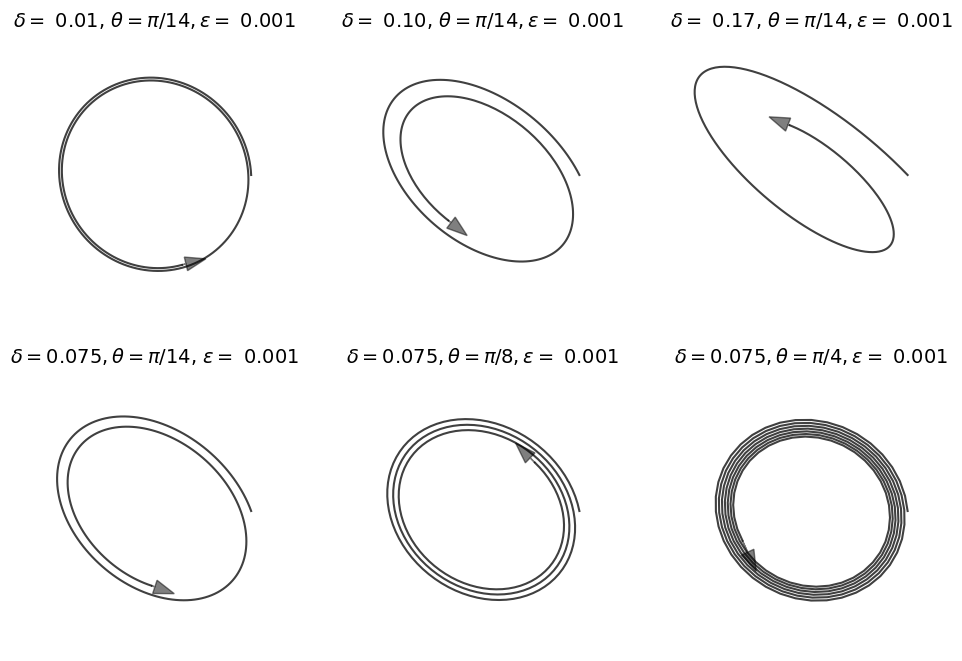

In [40]:
# Plot trajectories for fixed theta, varying delta, and then fixed delta, varying theta
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

th1 = np.pi/14
d1 = np.array([0.01, 0.1, 0.17])

d2 = 0.075
th2 = np.array([np.pi/14, np.pi/8, np.pi/4])
th2str = np.array([r'$\theta = \pi/14$, ', r'$\theta = \pi/8, $', r'$\theta = \pi/4, $'])


x0 = 1/np.sqrt(2) * np.array([1,0])

for i in range(3):

    # Map to continuous time and then sample the trajectory

    A = genA(th1, 1e-3, d1[i])[1]
    x = np.array([scipy.linalg.expm(A * k) @ x0 for k in np.linspace(0, 100, 250)])
    ax[0, i].plot(x[:, 0], x[:, 1], color='k', alpha=0.75)
    ax[0, i].arrow(x[-1, 0], x[-1, 1], 
            x[-1, 0] - x[-2, 0], x[-1, 1] - x[-2, 1], 
            head_width=0.1, color="k", alpha=0.5)

    ax[0, i].set_xlim([-1, 1])
    ax[0, i].set_ylim([-1, 1])

    ax[0, i].set_title(r"$\delta =$" + ' %.2f, ' % d1[i] +  r'$\theta = \pi/14, $' + r'$\epsilon =$' + ' %.3f' % 1e-3, fontsize=14)
    ax[0, i].axis('off')

    A = genA(th2[i], 1e-3, d2)[1]
    x = np.array([scipy.linalg.expm(A * k) @ x0 for k in np.linspace(0, 100, 250)])
    ax[1, i].plot(x[:, 0], x[:, 1], color='k', alpha=0.75)
    ax[1, i].arrow(x[-1, 0], x[-1, 1], 
            x[-1, 0] - x[-2, 0], x[-1, 1] - x[-2, 1], 
            head_width=0.1, color="k", alpha=0.5)

    ax[1, i].set_xlim([-1, 1])
    ax[1, i].set_ylim([-1, 1])

    ax[1, i].set_title(r"$\delta = 0.075, $" + th2str[i] + r'$\epsilon =$' + ' %.3f' % 1e-3, fontsize=14)
    ax[1, i].axis('off')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/2Dtraj_examples.pdf', bbox_inches='tight', pad_inches=0)


In [5]:
def LQG_score(A):
    P = scipy.linalg.solve_continuous_are(A, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))
    Q = scipy.linalg.solve_continuous_are(A.T, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))      
    return np.trace(P @ Q)

def FCCA_score(A):
    # Normalize by variance 
    Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
    Pi = 0.5 * (Pi + Pi.T)
    # Calculate the ground truth LQG score
    Q = scipy.linalg.solve_continuous_are(A.T, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))
    P = scipy.linalg.solve_continuous_are(A, Pi, np.linalg.matrix_power(Pi, -2), np.eye(A.shape[0]))
    return np.trace(P @ Q)

In [6]:
# Plot the spectrum of Ac as theta varies for a few value sof delta
theta = np.linspace(0, np.pi/3, 250)
delta = np.linspace(0, 0.2, 250)

iml = np.zeros((theta.size, len(delta)))
ssnorm = np.zeros((theta.size, len(delta)))
lqgscore = np.zeros((theta.size, len(delta)))
fccascore = np.zeros((theta.size, len(delta)))
pcascore = np.zeros((theta.size, len(delta)))

Ad = np.zeros((theta.size, len(delta)), dtype=object)
Ac_ = np.zeros((theta.size, len(delta)), dtype=object)

re_eig = np.zeros((theta.size, len(delta)))
im_eig = np.zeros((theta.size, len(delta)))
s = np.zeros((theta.size, len(delta)))
eigsymm = np.zeros((theta.size, len(delta)))

for i in range(theta.size):
    for j in range(len(delta)):
        A, Ac = genA(theta[i], 0.1, delta[j])
        Ad[i, j] = A
        Ac_[i, j] = Ac
        eigvals = np.linalg.eigvals(Ac)
        _, s_, _ = np.linalg.svd(Ac)
        s[i, j] = np.sum(s_)
        re_eig[i, j] = np.max(np.real(eigvals))
        im_eig[i, j] = np.sum(np.abs(np.imag(eigvals)))
        eigvals = np.linalg.eigvals(0.5 * (Ac + Ac.T))
        eigsymm[i, j] = np.max(eigvals)
        try:
            assert(np.max(np.real(np.linalg.eigvals(Ac))) < 0)
        except:
            # print(delta[j])
            lqgscore[i, j] = np.nan
            fccascore[i, j] = np.nan
            pcascore[i, j] = np.nan
            continue            
        # iml[i, j] = np.imag(np.linalg.eigvals(Ac)[0])
        # ssnorm[i, j] = np.linalg.norm(Ac - 0.5 * (Ac - Ac.T))/np.linalg.norm(Ac)
        lqgscore[i, j] = LQG_score(Ac)
        fccascore[i, j] = FCCA_score(Ac)
        pcascore[i, j] = np.linalg.slogdet(scipy.linalg.solve_continuous_lyapunov(Ac, np.eye(Ac.shape[0])))[1]

In [6]:
import matplotlib.patches as mpatches

In [7]:
from mpl_toolkits.axisartist.axislines import SubplotZero

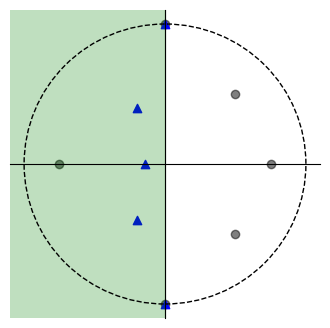

In [200]:
fig, ax = plt.subplots(figsize=(4, 4))

# Show example eigenvalues and how they get mapped via Cayley transform
e1 = np.array([-0.75, 0.75, 1j, -1j, 0.5 + 0.5j, 0.5 - 0.5j], dtype=complex)
e2 = -1 * (1 - e1)/(1 + e1)

ax.scatter(np.real(e1), np.imag(e1), color='k', alpha=0.5)
ax.scatter(np.real(e2), np.imag(e2), color='b', marker='^')

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

ax.set_xticks([])
ax.set_yticks([])

ax.fill_between([0, -2], [-2, -2], [2, 2], color='g', alpha=0.25)

circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax.add_patch(circle1)

fig.savefig('/home/akumar/nse/neural_control/figs/synth/eig_cayley.pdf', bbox_inches='tight', pad_inches=0)

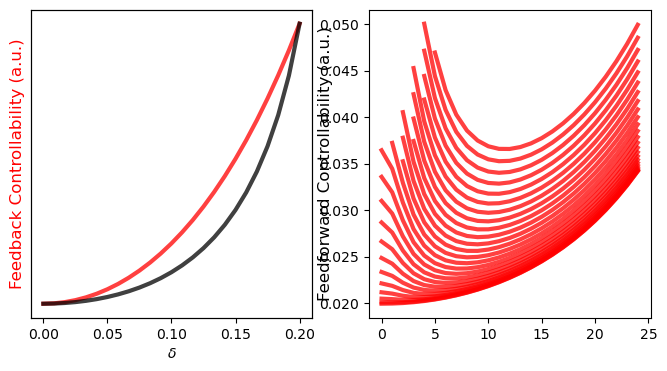

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax2 = ax[0].twinx()

ax[0].plot(delta, fccascore[5, :], color='r', linewidth=3, alpha=0.7delta = np.linspace(0, 0.1)
theta = np.linspace(0, 1)
5)
ax2.plot(delta, pcascore[5, :], color='k', linewidth=3, alpha=0.75)

#red_patch = mpatches.Patch(color='red', label='FBC', alpha=0.75)
#black_patch = mpatches.Patch(color='black', label='FFC', alpha=0.75)
#ax.legend(handles = [red_patch, black_patch], loc = 'center left', fontsize=16)
ax[0].set_xlabel(r'$\delta$')
ax[0].set_ylabel('Feedback Controllability (a.u.)', color='red', fontsize=12)
ax2.set_ylabel('Feedforward Controllability (a.u.)', fontsize=12)
ax[0].set_yticks([])
ax2.set_yticks([])
#ax.set_xlabel(r'$||A - A_{ss}||/||A||$' + ' (a.u.)', fontsize=18)
#fig.savefig('rotational_dependence.pdf', bbox_inches='tight', pad_inches=0)

ax[1].plot(fccascore[:, ], color='r', linewidth=3, alpha=0.75)

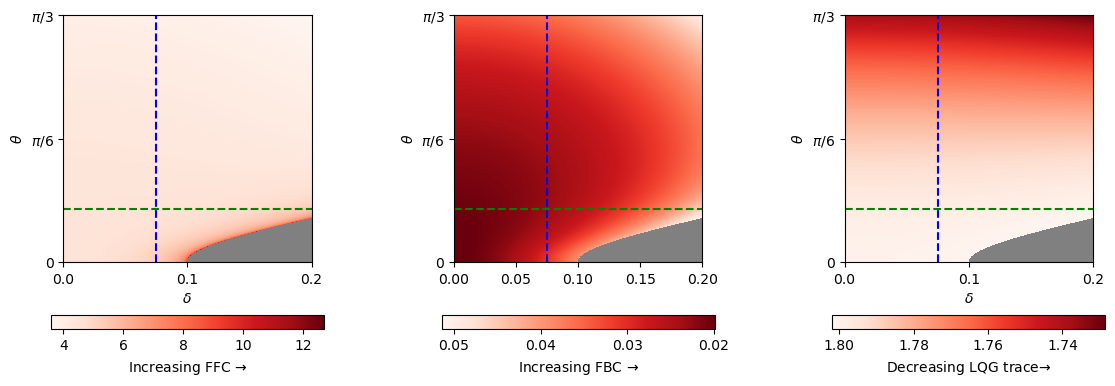

In [17]:
#fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection':'3d'})
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# X, Y = np.meshgrid(theta, delta)
# ax[0].plot_surface(X, Y, fccascore)
# ax[1].plot_surface(X, Y, pcascore)
cmap = copy(matplotlib.cm.get_cmap('Reds'))
cmap.set_bad(color='grey')
epca = pcascore

im0 = ax[0].imshow(epca, vmin=np.nanmin(epca), vmax=np.nanmax(epca), cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[0].invert_yaxis()
ax[0].set_aspect(0.19)
ax[0].set_yticks([0, np.pi/6, np.pi/3])
ax[0].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[0].set_ylabel(r'$\theta$')

ax[0].set_xticks([0., 0.1, 0.2])
ax[0].set_xlabel(r'$\delta$')
cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
cb.ax.set_xlabel('Increasing FFC ' + r'$\to$')


cmap = copy(matplotlib.cm.get_cmap('Reds_r'))
cmap.set_bad(color='grey')
epca = pcascore
im1 = ax[1].imshow(fccascore, vmin=np.nanmin(fccascore), vmax=np.nanmax(fccascore), cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[1].invert_yaxis()
ax[1].set_aspect(0.19)
ax[1].set_yticks([0, np.pi/6, np.pi/3])
ax[1].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[1].set_ylabel(r'$\theta$')

cb = fig.colorbar(im1, ax=ax[1], orientation='horizontal', shrink=0.75)
cb.ax.invert_xaxis()
cb.ax.set_xlabel('Increasing FBC ' + r'$\to$')


cmap = copy(matplotlib.cm.get_cmap('Reds_r'))
cmap.set_bad(color='grey')
im2 = ax[2].imshow(lqgscore, vmin=np.nanmin(lqgscore), vmax=np.nanmax(lqgscore), cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[2].invert_yaxis()
ax[2].set_aspect(0.19)

ax[2].set_yticks([0, np.pi/6, np.pi/3])
ax[2].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[2].set_ylabel(r'$\theta$')
ax[2].set_xticks([0., 0.1, 0.2])
ax[2].set_xlabel(r'$\delta$')

# Add horizontal lines to cutout parts of parameter space
ax[0].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
ax[0].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

ax[1].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
ax[1].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

ax[2].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
ax[2].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

cb = fig.colorbar(im2, ax=ax[2], orientation='horizontal', shrink=0.75)
cb.ax.invert_xaxis()
cb.ax.set_xlabel('Decreasing LQG trace' + r'$\to$')


fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/2Drot1_lqg.pdf', bbox_inches='tight', pad_inches=0)

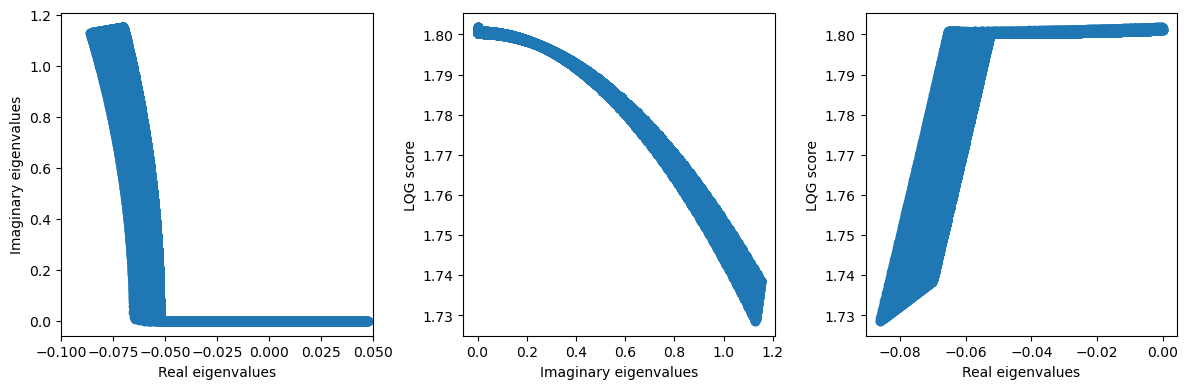

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(re_eig.ravel(), im_eig.ravel())
ax[0].set_ylabel('Imaginary eigenvalues')
ax[0].set_xlabel('Real eigenvalues')
ax[0].set_xlim([-.1, .050])

ax[1].scatter(im_eig.ravel(), lqgscore.ravel())
ax[1].set_xlabel('Imaginary eigenvalues')
ax[1].set_ylabel('LQG score')

ax[2].scatter(re_eig.ravel(), lqgscore.ravel())
ax[2].set_xlabel('Real eigenvalues')
ax[2].set_ylabel('LQG score')

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/2Drot_debug1.pdf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_16598/3742384916.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax[0].pcolor(delta, theta, re_eig, cmap='Reds')
/tmp/ipykernel_16598/3742384916.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[1].pcolor(delta, theta, im_eig, cmap='Reds')
/tmp/ipykernel_16598/3742384916.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the 

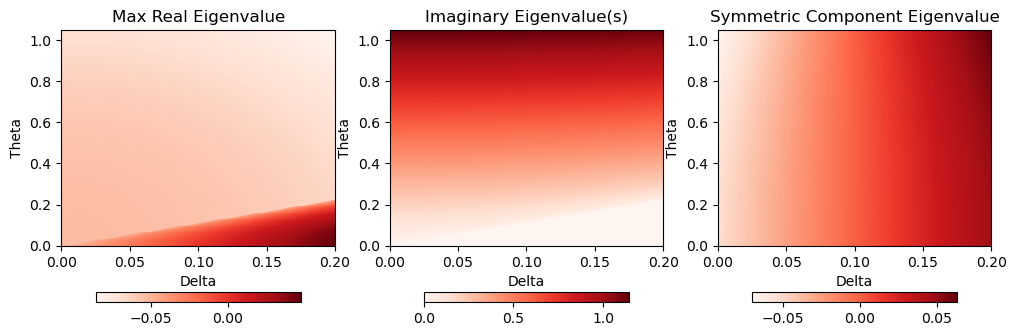

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im0 = ax[0].pcolor(delta, theta, re_eig, cmap='Reds')
ax[0].set_title('Max Real Eigenvalue')
cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
im1 = ax[1].pcolor(delta, theta, im_eig, cmap='Reds')
ax[1].set_title('Imaginary Eigenvalue(s)')
cb = fig.colorbar(im1, ax=ax[1], orientation='horizontal', shrink=0.75)
im2 = ax[2].pcolor(delta, theta, eigsymm, cmap='Reds')
ax[2].set_title('Symmetric Component Eigenvalue')
cb = fig.colorbar(im2, ax=ax[2], orientation='horizontal', shrink=0.75)

for a in ax:
    a.set_ylabel('Theta')
    a.set_xlabel('Delta')

fig.savefig('/home/akumar/nse/neural_control/figs/synth/2Drot_debug2.pdf', bbox_inches='tight', pad_inches=0)

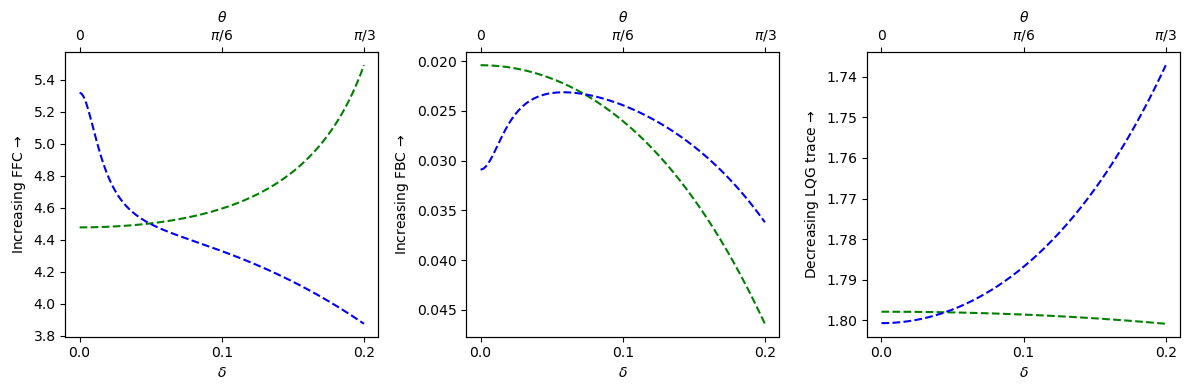

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Plot data along the green and blue contours
idx1 = np.argmin(np.abs(theta - np.pi/14))
ax[0].plot(delta, pcascore[idx1, :], 'g', linestyle='dashed')
a = ax[0].twiny()
idx2 = np.argmin(np.abs(delta - 0.075))
a.plot(theta, pcascore[:, idx2], 'b', linestyle='dashed')
ax[0].set_ylabel('Increasing FFC ' + r'$\to$')
ax[0].set_xticks([0, 0.1, 0.2])
ax[0].set_xlabel(r'$\delta$')

a.set_xticks([0, np.pi/6, np.pi/3])
a.set_xticklabels([0, r'$\pi/6$', r'$\pi/3$'])
a.set_xlabel(r'$\theta$')


idx1 = np.argmin(np.abs(theta - np.pi/14))
ax[1].plot(delta, fccascore[idx1, :], 'g', linestyle='dashed')
a = ax[1].twiny()
idx2 = np.argmin(np.abs(delta - 0.075))
a.plot(theta, fccascore[:, idx2], 'b', linestyle='dashed')
ax[1].invert_yaxis()
ax[1].set_ylabel('Increasing FBC ' + r'$\to$')
ax[1].set_xticks([0, 0.1, 0.2])
ax[1].set_xlabel(r'$\delta$')

a.set_xticks([0, np.pi/6, np.pi/3])
a.set_xticklabels([0, r'$\pi/6$', r'$\pi/3$'])
a.set_xlabel(r'$\theta$')


idx1 = np.argmin(np.abs(theta - np.pi/14))
ax[2].plot(delta, lqgscore[idx1, :], 'g', linestyle='dashed')
a = ax[2].twiny()
idx2 = np.argmin(np.abs(delta - 0.075))
a.plot(theta, lqgscore[:, idx2], 'b', linestyle='dashed')
ax[2].invert_yaxis()
ax[2].set_ylabel('Decreasing LQG trace ' + r'$\to$')
ax[2].set_xticks([0, 0.1, 0.2])
ax[2].set_xlabel(r'$\delta$')

a.set_xticks([0, np.pi/6, np.pi/3])
a.set_xticklabels([0, r'$\pi/6$', r'$\pi/3$'])
a.set_xlabel(r'$\theta$')


fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/2Drot2_lqg.pdf', bbox_inches='tight', pad_inches=0)

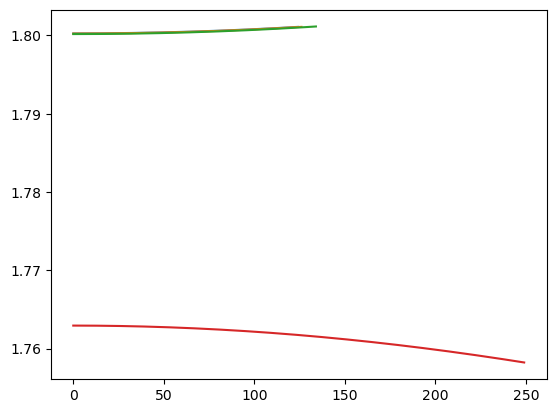

In [13]:
plt.plot(lqgscore[0, :])
plt.plot(lqgscore[5, :])
plt.plot(lqgscore[10, :])
plt.plot(lqgscore[200, :])

### Doing the analysis natively by tuning the relative strength of the symmetric and asymmetric parts of the matrix

In [6]:
theta = np.linspace(0, np.pi/3, 250)
delta = np.linspace(0, 0.2, 250)

iml = np.zeros((theta.size, len(delta)))
ssnorm = np.zeros((theta.size, len(delta)))
lqgscore = np.zeros((theta.size, len(delta)))
fccascore = np.zeros((theta.size, len(delta)))
pcascore = np.zeros((theta.size, len(delta)))

Ad = np.zeros((theta.size, len(delta)), dtype=object)
Ac_ = np.zeros((theta.size, len(delta)), dtype=object)

for i in range(theta.size):
    for j in range(len(delta)):
        A, Ac = genA(theta[i], 0.1, delta[j])
        Ad[i, j] = A
        Ac_[i, j] = Ac

In [7]:
# Measure the relative symmetric/asymmetric norms
re_eig = np.zeros((theta.size, len(delta)))
im_eig = np.zeros((theta.size, len(delta)))

for i in range(theta.size):
    for j in range(len(delta)):
        re_eig[i, j] = np.sum(np.abs(np.real(np.linalg.eigvals(Ac_[i, j]))))
        im_eig[i, j] = np.sum(np.abs(np.imag(np.linalg.eigvals(Ac_[i, j]))))

/tmp/ipykernel_4694/1010904794.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolor(delta, theta, re_eig)
/tmp/ipykernel_4694/1010904794.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolor(delta, theta, im_eig)


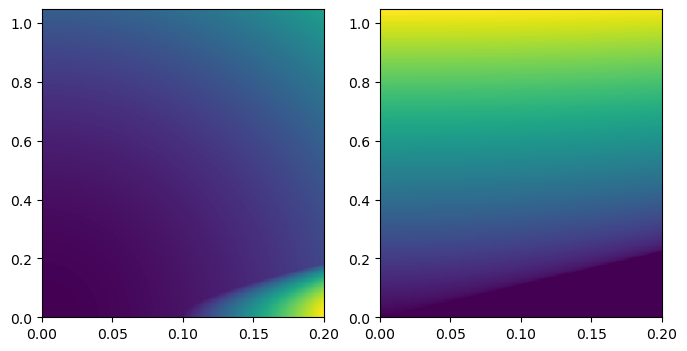

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].pcolor(delta, theta, re_eig)
ax[1].pcolor(delta, theta, im_eig)

In [15]:
A = np.array([[1, 0.25], [-0.25, 1]])

In [16]:
np.linalg.eigvals(A)

array([1.+0.25j, 1.-0.25j])

In [23]:
import pdb

In [18]:
# Now try directly modulating im/real components of the eigenvalues
a = np.linspace(-1, -0.01, 250)
b = np.linspace(0, 5, 250)

re_eig = np.zeros((a.size, b.size))
im_eig = np.zeros((a.size, b.size))
eigsymm = np.zeros((a.size, b.size))

lqgscore = np.zeros((a.size, b.size))
fccascore = np.zeros((a.size, b.size))
pcascore = np.zeros((a.size, b.size))


for i in range(a.size):
    for j in range(b.size):

        Ac = np.array([[a[i], -b[j]], [b[j], a[i]]])
        re_eig[i, j] = np.max(np.real(np.linalg.eigvals(Ac)))
        im_eig[i, j] = np.sum(np.abs(np.imag(np.linalg.eigvals(Ac))))

        eigvals = np.linalg.eigvals(0.5 * (Ac + Ac.T))
        eigsymm[i, j] = np.max(eigvals)

        lqgscore[i, j] = LQG_score(Ac)
        try:
            fccascore[i, j] = FCCA_score(Ac)
        except:
            pdb.set_trace()

        Pi = scipy.linalg.solve_continuous_lyapunov(Ac, -1*np.eye(Ac.shape[0]))
        Pi = 0.5 * (Pi + Pi.T)
        pcascore[i, j] = np.linalg.slogdet(Pi)[1]


/tmp/ipykernel_4694/1639085929.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax[0].pcolor(a, b, re_eig.T, cmap='Reds')
/tmp/ipykernel_4694/1639085929.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[1].pcolor(a, b, im_eig.T, cmap='Reds')
/tmp/ipykernel_4694/1639085929.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals 

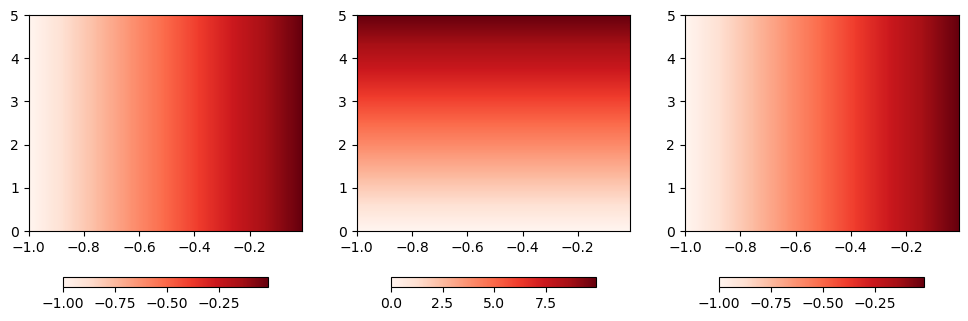

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im0 = ax[0].pcolor(a, b, re_eig.T, cmap='Reds')
cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
im1 = ax[1].pcolor(a, b, im_eig.T, cmap='Reds')
cb = fig.colorbar(im1, ax=ax[1], orientation='horizontal', shrink=0.75)
im2 = ax[2].pcolor(a, b, eigsymm.T, cmap='Reds')
cb = fig.colorbar(im2, ax=ax[2], orientation='horizontal', shrink=0.75)

/tmp/ipykernel_16598/1568871025.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax[0].pcolor(a, b, pcascore.T, cmap='Reds')
/tmp/ipykernel_16598/1568871025.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax[1].pcolor(a, b, fccascore.T, cmap='Reds')
/tmp/ipykernel_16598/1568871025.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadril

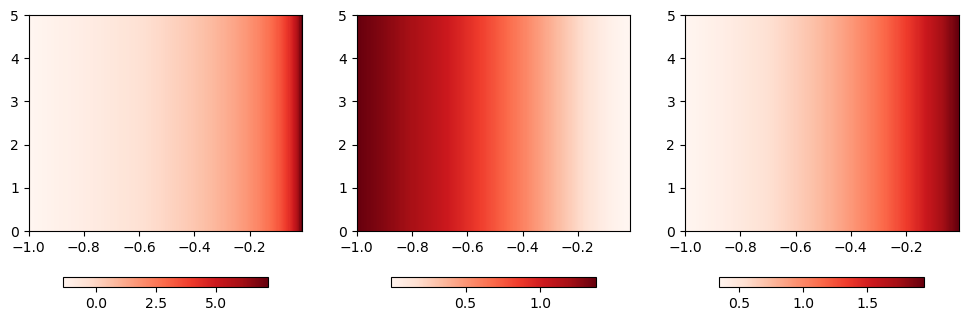

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im0 = ax[0].pcolor(a, b, pcascore.T, cmap='Reds')
cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
im0 = ax[1].pcolor(a, b, fccascore.T, cmap='Reds')
cb = fig.colorbar(im0, ax=ax[1], orientation='horizontal', shrink=0.75)
im0 = ax[2].pcolor(a, b, lqgscore.T, cmap='Reds')
cb = fig.colorbar(im0, ax=ax[2], orientation='horizontal', shrink=0.75)
fig.savefig('/home/akumar/nse/neural_control/figs/synth/2Drot_debug3.pdf')

In [28]:
#fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection':'3d'})
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# X, Y = np.meshgrid(theta, delta)
# ax[0].plot_surface(X, Y, fccascore)
# ax[1].plot_surface(X, Y, pcascore)
cmap = copy(matplotlib.cm.get_cmap('Reds'))
cmap.set_bad(color='grey')
epca = pcascore

im0 = ax[0].imshow(epca, vmin=np.nanmin(epca), vmax=np.nanmax(epca), cmap=cmap, extent=[a[0], a[-1], b[-1], b[0]])
ax[0].invert_yaxis()
ax[0].set_aspect(0.19)
ax[0].set_yticks([0, np.pi/6, np.pi/3])
ax[0].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[0].set_ylabel(r'$\theta$')

ax[0].set_xticks([0., 0.1, 0.2])
ax[0].set_xlabel(r'$\delta$')
cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
cb.ax.set_xlabel('Increasing FFC ' + r'$\to$')


cmap = copy(matplotlib.cm.get_cmap('Reds_r'))
cmap.set_bad(color='grey')
epca = pcascore
im1 = ax[1].imshow(fccascore, vmin=np.nanmin(fccascore), vmax=np.nanmax(fccascore), cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[1].invert_yaxis()
ax[1].set_aspect(0.19)
ax[1].set_yticks([0, np.pi/6, np.pi/3])
ax[1].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[1].set_ylabel(r'$\theta$')

cb = fig.colorbar(im1, ax=ax[1], orientation='horizontal', shrink=0.75)
cb.ax.invert_xaxis()
cb.ax.set_xlabel('Increasing FBC ' + r'$\to$')


cmap = copy(matplotlib.cm.get_cmap('Reds_r'))
cmap.set_bad(color='grey')
im2 = ax[2].imshow(lqgscore, vmin=np.nanmin(lqgscore), vmax=np.nanmax(lqgscore), cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[2].invert_yaxis()
ax[2].set_aspect(0.19)

ax[2].set_yticks([0, np.pi/6, np.pi/3])
ax[2].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[2].set_ylabel(r'$\theta$')
ax[2].set_xticks([0., 0.1, 0.2])
ax[2].set_xlabel(r'$\delta$')

# Add horizontal lines to cutout parts of parameter space
ax[0].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
ax[0].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

ax[1].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
ax[1].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

ax[2].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
ax[2].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

cb = fig.colorbar(im2, ax=ax[2], orientation='horizontal', shrink=0.75)
cb.ax.invert_xaxis()
cb.ax.set_xlabel('Decreasing LQG trace' + r'$\to$')


fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/synth/2Drot1_lqg.pdf', bbox_inches='tight', pad_inches=0)

ValueError: Matrix q should be symmetric/hermitian.

In [33]:
0.5 * (Pi + Pi.T)

array([[8.10546875, 0.        ],
       [0.        , 8.10546875]])

In [30]:
np.linalg.eigvals(Pi)

array([8.10546875+2.32194546e-14j, 8.10546875-2.32194546e-14j])

### Using alternative paramterization directly in continuous time

In [7]:
# Plot the spectrum of Ac as theta varies for a few value sof delta
#theta = np.linspace(0, np.pi/3, 250)
#delta = np.linspace(0, 0.2, 250)

delta = np.linspace(0, 0.1)
theta = np.linspace(0, 1)

iml = np.zeros((theta.size, len(delta)))
ssnorm = np.zeros((theta.size, len(delta)))
lqgscore = np.zeros((theta.size, len(delta)))
fccascore = np.zeros((theta.size, len(delta)))
pcascore = np.zeros((theta.size, len(delta)))

Ac_ = np.zeros((theta.size, len(delta)), dtype=object)

re_eig = np.zeros((theta.size, len(delta)))
im_eig = np.zeros((theta.size, len(delta)))
# s = np.zeros((theta.size, len(delta)))
eigsymm = np.zeros((theta.size, len(delta)))
eigskew = np.zeros((theta.size, len(delta)))
for i in range(theta.size):
    for j in range(len(delta)):
        # A, Ac = genA(theta[i], 0.1, delta[j])
        # Ad[i, j] = A
        Ac = np.array([[-1 - delta[j], theta[i]], [-1*theta[i], -1 + delta[j]]])
        Ac_[i, j] = Ac
        eigvals = np.linalg.eigvals(Ac)
        # # _, s_, _ = np.linalg.svd(Ac)
        # s[i, j] = np.sum(s_)
        re_eig[i, j] = np.max(np.real(eigvals))
        im_eig[i, j] = np.sum(np.abs(np.imag(eigvals)))
        eigvals = np.linalg.eigvals(0.5 * (Ac + Ac.T))
        eigsymm[i, j] = np.max(eigvals)
        eigvals = np.linalg.eigvals(0.5 * (Ac - Ac.T))
        eigskew[i, j] = np.abs(np.imag(eigvals[0]))
        try:
            assert(np.max(np.real(np.linalg.eigvals(Ac))) < 0)
        except:
            # print(delta[j])
            lqgscore[i, j] = np.nan
            fccascore[i, j] = np.nan
            pcascore[i, j] = np.nan
            continue            

        eigvals = np.linspace(-1, 1, 100)

        # iml[i, j] = np.imag(np.linalg.eigvals(Ac)[0])
        # ssnorm[i, j] = np.linalg.norm(Ac - 0.5 * (Ac - Ac.T))/np.linalg.norm(Ac)
        try:
            lqgscore[i, j] = LQG_score(Ac)
        except:
            lqgscore[i, j] = np.nan

        try:
            fccascore[i, j] = FCCA_score(Ac)
        except:
            fccascore[i, j] = np.nan
    
        try:
            pcascore[i, j] = np.linalg.slogdet(scipy.linalg.solve_continuous_lyapunov(Ac, np.eye(Ac.shape[0])))[1]
        except:
            pcascore[i, j] = np.nan

In [21]:
epca

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [5.01769366e+00,            nan,            nan, ...,
                   nan,            nan,            nan],
       [3.65106400e+00,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [6.57243699e-02, 1.09950689e-01, 1.55122970e-01, ...,
        6.69942743e+00, 8.09316557e+00,            nan],
       [6.30980718e-02, 1.07194221e-01, 1.52232241e-01, ...,
        6.68499214e+00, 8.07831846e+00,            nan],
       [6.06246218e-02, 1.04599008e-01, 1.49511494e-01, ...,
        6.67161871e+00, 8.06456901e+00, 6.93668341e+01]])

In [23]:
np.nanmin(epca)

-inf

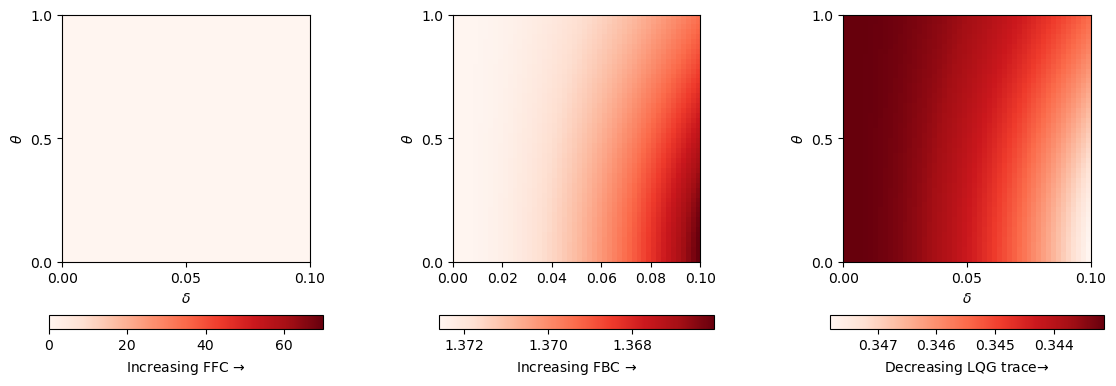

In [38]:
#fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection':'3d'})
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

aspect = 0.1
yticks = [0,0.5, 1.0]
xticks = [0., 0.05, 0.1]

# X, Y = np.meshgrid(theta, delta)
# ax[0].plot_surface(X, Y, fccascore)
# ax[1].plot_surface(X, Y, pcascore)
cmap = copy(matplotlib.cm.get_cmap('Reds'))
cmap.set_bad(color='grey')
epca = pcascore

im0 = ax[0].imshow(epca, vmin=0, vmax=70, cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[0].invert_yaxis()
ax[0].set_aspect(aspect)
ax[0].set_yticks(yticks)
#ax[0].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[0].set_ylabel(r'$\theta$')

ax[0].set_xticks(xticks)
ax[0].set_xlabel(r'$\delta$')
cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
cb.ax.set_xlabel('Increasing FFC ' + r'$\to$')


cmap = copy(matplotlib.cm.get_cmap('Reds_r'))
cmap.set_bad(color='grey')
epca = pcascore
im1 = ax[1].imshow(fccascore, vmin=np.nanmin(fccascore), vmax=np.nanmax(fccascore), cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[1].invert_yaxis()
ax[1].set_aspect(aspect)
ax[1].set_yticks(yticks)
#ax[1].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[1].set_ylabel(r'$\theta$')   

cb = fig.colorbar(im1, ax=ax[1], orientation='horizontal', shrink=0.75)
cb.ax.invert_xaxis()
cb.ax.set_xlabel('Increasing FBC ' + r'$\to$')


cmap = copy(matplotlib.cm.get_cmap('Reds_r'))
cmap.set_bad(color='grey')
im2 = ax[2].imshow(lqgscore, vmin=np.nanmin(lqgscore), vmax=np.nanmax(lqgscore), cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[2].invert_yaxis()
ax[2].set_aspect(aspect)

ax[2].set_yticks(yticks)
#ax[2].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[2].set_ylabel(r'$\theta$')
ax[2].set_xticks(xticks)
ax[2].set_xlabel(r'$\delta$')

# Add horizontal lines to cutout parts of parameter space
# ax[0].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
# ax[0].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

# ax[1].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
# ax[1].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

# ax[2].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
# ax[2].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

cb = fig.colorbar(im2, ax=ax[2], orientation='horizontal', shrink=0.75)
cb.ax.invert_xaxis()
cb.ax.set_xlabel('Decreasing LQG trace' + r'$\to$')


fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/synth/2Drot1_lqg.pdf', bbox_inches='tight', pad_inches=0)

In [40]:
pcascore

array([[-1.38629436, -1.3862902 , -1.3862777 , ..., -1.37705144,
        -1.37665202, -1.37624403],
       [-1.38629436, -1.3862902 , -1.38627771, ..., -1.37705531,
        -1.37665605, -1.37624823],
       [-1.38629436, -1.3862902 , -1.38627773, ..., -1.37706689,
        -1.37666814, -1.37626083],
       ...,
       [-1.38629436, -1.38629219, -1.38628568, ..., -1.38149109,
        -1.381284  , -1.38107251],
       [-1.38629436, -1.38629224, -1.38628586, ..., -1.3815883 ,
        -1.38138541, -1.38117821],
       [-1.38629436, -1.38629228, -1.38628603, ..., -1.38168358,
        -1.38148481, -1.38128182]])

In [39]:
fccascore[:, 20]

array([1.37149688, 1.37149733, 1.3714987 , 1.37150098, 1.37150415,
       1.3715082 , 1.37151311, 1.37151886, 1.37152544, 1.37153279,
       1.37154091, 1.37154975, 1.37155928, 1.37156945, 1.37158024,
       1.3715916 , 1.37160348, 1.37161586, 1.37162868, 1.3716419 ,
       1.37165549, 1.3716694 , 1.37168359, 1.37169802, 1.37171265,
       1.37172745, 1.37174238, 1.37175741, 1.37177251, 1.37178764,
       1.37180278, 1.37181789, 1.37183296, 1.37184797, 1.37186288,
       1.37187768, 1.37189235, 1.37190687, 1.37192124, 1.37193542,
       1.37194943, 1.37196323, 1.37197683, 1.37199021, 1.37200337,
       1.3720163 , 1.372029  , 1.37204145, 1.37205367, 1.37206565])

In [27]:
lqgscore[:, 20]

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 1.88292726, 1.83865556, 1.79543511, 1.7535327 ,
       1.7131648 , 1.67449908, 1.63765732, 1.60271926, 1.56972711,
       1.53869049, 1.50959145, 1.48238942, 1.45702586, 1.4334286 ,
       1.4115156 , 1.39119829, 1.37238437, 1.35498013, 1.3388923 ,
       1.32402947, 1.31030324, 1.29762895, 1.28592623, 1.27511933,
       1.26513728, 1.25591388, 1.2473877 , 1.23950189, 1.23220398,
       1.2254457 , 1.21918269, 1.21337428, 1.20798321, 1.20297538])

/tmp/ipykernel_28995/2008117.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax[0].pcolor(delta, theta, re_eig, cmap='Reds')
/tmp/ipykernel_28995/2008117.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[1].pcolor(delta, theta, im_eig, cmap='Reds')
/tmp/ipykernel_28995/2008117.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilat

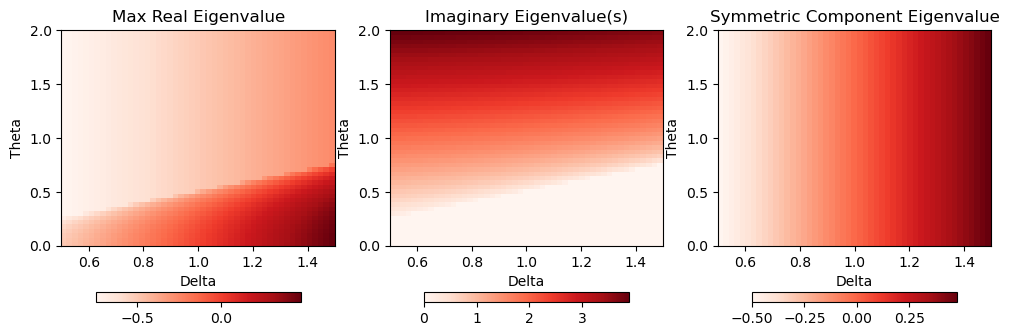

In [33]:
# Eigenvalue behavior
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im0 = ax[0].pcolor(delta, theta, re_eig, cmap='Reds')
ax[0].set_title('Max Real Eigenvalue')
cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
im1 = ax[1].pcolor(delta, theta, im_eig, cmap='Reds')
ax[1].set_title('Imaginary Eigenvalue(s)')
cb = fig.colorbar(im1, ax=ax[1], orientation='horizontal', shrink=0.75)
im2 = ax[2].pcolor(delta, theta, eigsymm, cmap='Reds')
ax[2].set_title('Symmetric Component Eigenvalue')
cb = fig.colorbar(im2, ax=ax[2], orientation='horizontal', shrink=0.75)

for a in ax:
    a.set_ylabel('Theta')
    a.set_xlabel('Delta')


In [22]:
import pdb

In [6]:
# Why does this attempt at a direct parameterization behave so differently? What are the other axes along which these matrices can vary?

theta = np.linspace(0, np.pi/3, 250)
delta = np.linspace(0, 0.2, 250)

delta2 = np.linspace(0, 0.5, 250)
theta2 = np.linspace(0, 0.5, 250)

Ad = np.zeros((theta.size, len(delta)), dtype=object)
Ac_ = np.zeros((theta.size, len(delta)), dtype=object)
Ac2_ = np.zeros((theta.size, len(delta)), dtype=object)

re_eig = np.zeros((theta.size, len(delta), 2, 2))
im_eig = np.zeros((theta.size, len(delta), 2, 2))
# s = np.zeros((theta.size, len(delta)))
eigsymm = np.zeros((theta.size, len(delta), 2, 2))
eigskew = np.zeros((theta.size, len(delta), 2, 2))

lqgscore = np.zeros((theta.size, len(delta), 2))
fccascore = np.zeros((theta.size, len(delta), 2))
pcascore = np.zeros((theta.size, len(delta), 2))

# Condition nubmers and total eigenvalues
cond_numbers = np.zeros((theta.size, len(delta), 2))

for i in range(theta.size):
    for j in range(len(delta)):
        A, Ac = genA(theta[i], 0.1, delta[j])
        Ad[i, j] = A
        Ac_[i, j] = Ac
        Ac2 = np.array([[-0.05 - delta2[j], theta2[i]], [-1*theta2[i], -0.05 + delta2[j]]])
        Ac2_[i, j] = Ac2 

        cond_numbers[i, j, 0] = np.linalg.cond(Ac)
        cond_numbers[i, j, 1] = np.linalg.cond(Ac2)

        eigvals = np.linalg.eigvals(Ac)
        re_eig[i, j, :, 0] = np.real(eigvals)
        im_eig[i, j, :, 0] = np.imag(eigvals)
        eigvals = np.linalg.eigvals(0.5 * (Ac + Ac.T))
        eigsymm[i, j, :, 0] = eigvals
        eigvals = np.linalg.eigvals(0.5 * (Ac - Ac.T))
        eigskew[i, j, :, 0] = np.imag(eigvals)

        eigvals = np.linalg.eigvals(Ac2)
        re_eig[i, j, :, 1] = np.real(eigvals)
        im_eig[i, j, :, 1] = np.imag(eigvals)
        eigvals = np.linalg.eigvals(0.5 * (Ac2 + Ac2.T))
        eigsymm[i, j, :, 1] = eigvals
        eigvals = np.linalg.eigvals(0.5 * (Ac2 - Ac2.T))
        eigskew[i, j, :, 1] = np.imag(eigvals)

        try:
            assert(np.max(np.real(np.linalg.eigvals(Ac2))) < 0)
        except:
            # print(delta[j])
            lqgscore[i, j, 1] = np.nan
            fccascore[i, j, 1] = np.nan
            pcascore[i, j, 1] = np.nan
            continue            
        # iml[i, j] = np.imag(np.linalg.eigvals(Ac)[0])
        # ssnorm[i, j] = np.linalg.norm(Ac - 0.5 * (Ac - Ac.T))/np.linalg.norm(Ac)

        lqgscore[i, j, 1] = LQG_score(Ac2)
        fccascore[i, j, 1] = FCCA_score(Ac2)
        pcascore[i, j, 1] = np.linalg.slogdet(scipy.linalg.solve_continuous_lyapunov(Ac2, np.eye(Ac.shape[0])))[1]


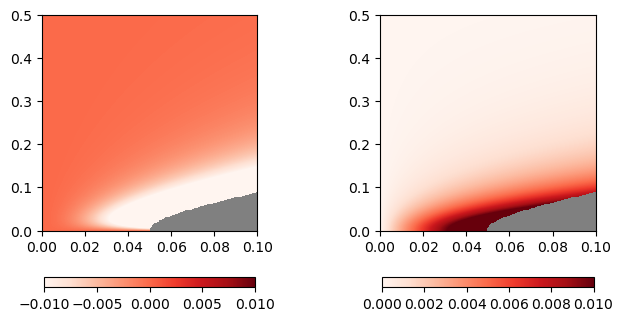

In [30]:
# Plot the differences along the axes
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


i = 1
xx = fccascore[..., i]
xx[np.isclose(xx, 0)] = np.nan
xx -= np.nanmin(xx)
xx /= np.nanmax(xx)

cmap = copy(matplotlib.cm.get_cmap('Reds'))
cmap.set_bad(color='grey')

im2 = ax[0].imshow(np.diff(xx, axis=0)[:, :-1], cmap=cmap, vmin=-0.01, vmax=0.01,
                        extent=[delta2[0], delta2[-1], theta2[-1], theta2[0]])
cb = fig.colorbar(im2, ax=ax[0], orientation='horizontal', shrink=0.75)
ax[0].invert_yaxis()
ax[0].set_aspect(0.2)

im2 = ax[1].imshow(np.diff(xx, axis=1)[:-1, :], cmap=cmap, vmin=0.00, vmax=0.01,
                        extent=[delta2[0], delta2[-1], theta2[-1], theta2[0]])
cb = fig.colorbar(im2, ax=ax[1], orientation='horizontal', shrink=0.75)
ax[1].invert_yaxis()
ax[1].set_aspect(0.2)

In [66]:
np.quantile(cond_numbers.ravel(), 0.99)

51.04456522114912

In [67]:
# Set unrealistically large condition numbers to np.nan
cond_numbers[cond_numbers > 100] = np.nan

(array([1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00,
        1.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
        2.0000e+00, 4.0000e+00, 3.0000e+00, 6.0000e+00, 9.0000e+00,
        4.0000e+00, 5.2279e+04, 3.9120e+03, 2.4500e+03, 1.2010e+03,
        7.4200e+02, 4.0700e+02, 2.1800e+02, 1.4900e+02, 1.0900e+02,
        8.2000e+01, 6.6000e+01, 5.0000e+01, 4.6000e+01, 3.6000e+01,
        3.0000e+01, 3.2000e+01, 2.4000e+01, 1.6000e+01, 2.1000e+01,
        2.4000e+01, 1.0000e+01, 1.7000e+01, 7.0000e+00, 1.4000e+01,
        1.4000e+01, 6.0000e+00, 9.0000e+00, 1.3000e+01, 4.0000e+00,
        6.0000e+00, 4.0000e+00, 1.1000e+01, 3.0000e+00, 1.0000e+00,
        4.0000e+00, 5.0000e+00, 3.0000e+00, 9.0000e+00, 6.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00,
        2.0000e+00, 9.0000e+00, 0.0000e+00, 1.00

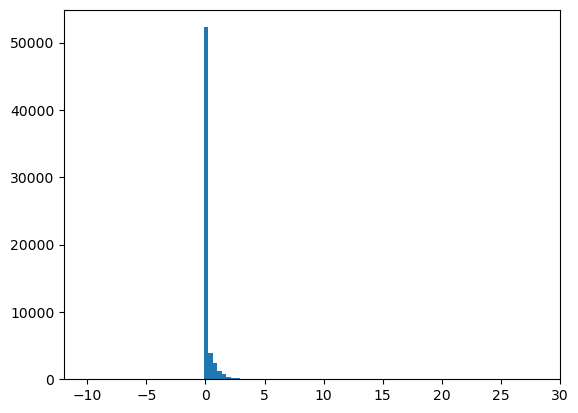

In [69]:
plt.hist(cond_numbers[..., 0].ravel() - cond_numbers[..., 1].ravel(), bins=100)

/tmp/ipykernel_22518/136115318.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax[0, i].pcolor(delta, theta, re_eig[..., 0, i], cmap='Reds')
/tmp/ipykernel_22518/136115318.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax[1, i].pcolor(delta, theta, re_eig[..., 1, i], cmap='Reds')
/tmp/ipykernel_22518/136115318.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either s

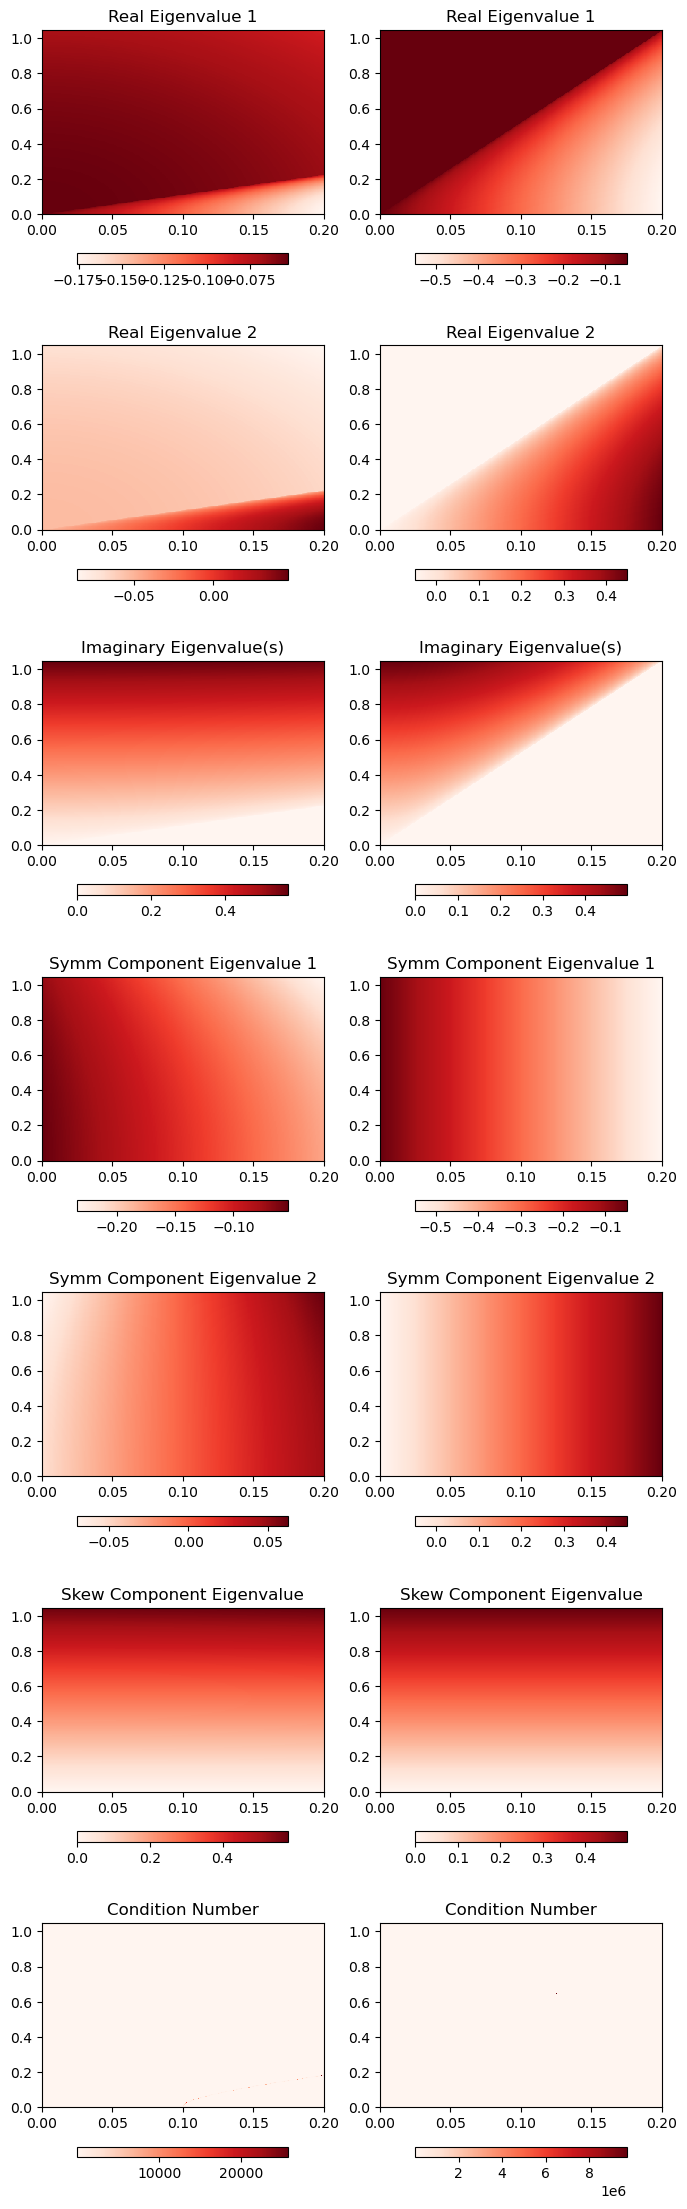

In [16]:
fig, ax = plt.subplots(7, 2, figsize=(8, 28))

for i in range(2):
    im0 = ax[0, i].pcolor(delta, theta, re_eig[..., 0, i], cmap='Reds')
    ax[0, i].set_title('Real Eigenvalue 1')
    cb = fig.colorbar(im0, ax=ax[0, i], orientation='horizontal', shrink=0.75)

    im0 = ax[1, i].pcolor(delta, theta, re_eig[..., 1, i], cmap='Reds')
    ax[1, i].set_title('Real Eigenvalue 2')
    cb = fig.colorbar(im0, ax=ax[1, i], orientation='horizontal', shrink=0.75)


    im1 = ax[2, i].pcolor(delta, theta, np.abs(im_eig[..., 0, i]), cmap='Reds')
    ax[2, i].set_title('Imaginary Eigenvalue(s)')
    cb = fig.colorbar(im1, ax=ax[2, i], orientation='horizontal', shrink=0.75)

    im2 = ax[3, i].pcolor(delta, theta, eigsymm[..., 0, i], cmap='Reds')
    ax[3, i].set_title('Symm Component Eigenvalue 1') 
    cb = fig.colorbar(im2, ax=ax[3, i], orientation='horizontal', shrink=0.75)

    im2 = ax[4, i].pcolor(delta, theta, eigsymm[..., 1, i], cmap='Reds')
    ax[4, i].set_title('Symm Component Eigenvalue 2') 
    cb = fig.colorbar(im2, ax=ax[4, i], orientation='horizontal', shrink=0.75)

    im2 = ax[5, i].pcolor(delta, theta, np.abs(eigskew[..., 0, i]), cmap='Reds')
    ax[5, i].set_title('Skew Component Eigenvalue')
    cb = fig.colorbar(im2, ax=ax[5, i], orientation='horizontal', shrink=0.75)

    im2 = ax[6, i].pcolor(delta, theta, np.abs(cond_numbers[..., i]), cmap='Reds')
    ax[6, i].set_title('Condition Number')
    cb = fig.colorbar(im2, ax=ax[6, i], orientation='horizontal', shrink=0.75)

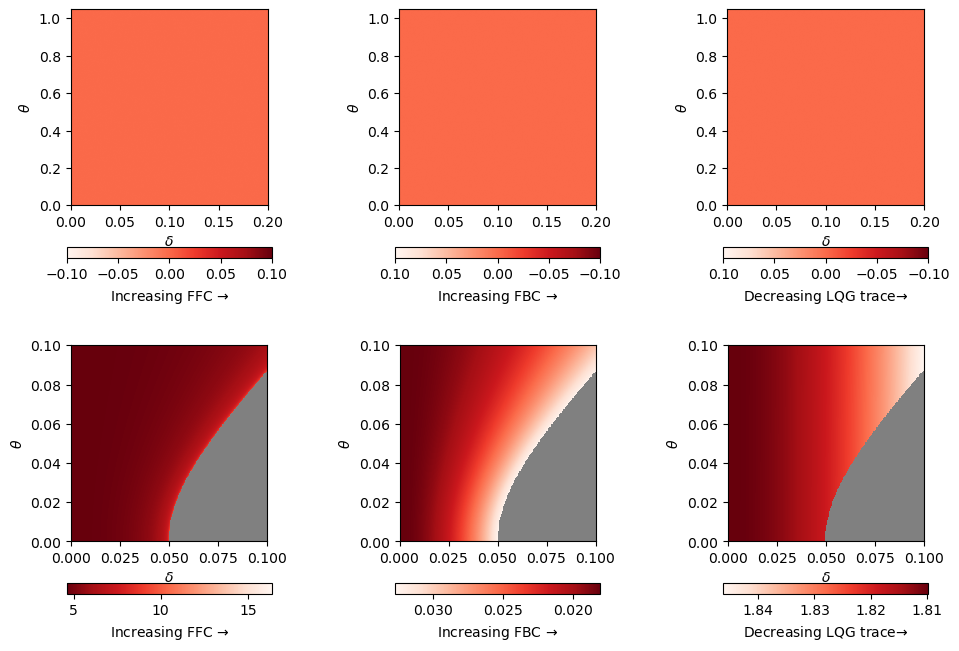

In [46]:
# Now compare the resulting scores...
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# X, Y = np.meshgrid(theta, delta)
# ax[0].plot_surface(X, Y, fccascore)
# ax[1].plot_surface(X, Y, pcascore)
cmap = copy(matplotlib.cm.get_cmap('Reds'))
cmap.set_bad(color='grey')
epca = pcascore

d = [delta, delta2]
t = [theta, theta2]
aspect = [0.19, 1]
for i in range(2):
    im0 = ax[i, 0].imshow(epca[..., i], vmin=np.nanmin(epca[..., i]), 
                        vmax=np.nanmax(epca[..., i]), cmap=cmap, extent=[d[i][0], 
                                                                         d[i][-1], t[i][-1], t[i][0]])
    ax[i, 0].invert_yaxis()
    ax[i, 0].set_aspect(aspect[i])
    # ax[i, 0].set_yticks([0, np.pi/6, np.pi/3])
    # ax[i, 0].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
    ax[i, 0].set_ylabel(r'$\theta$')
    # ax[i, 0].set_xticks([0., 0.1, 0.2])
    ax[i, 0].set_xlabel(r'$\delta$')
    cb = fig.colorbar(im0, ax=ax[i, 0], orientation='horizontal', shrink=0.75)
    cb.ax.set_xlabel('Increasing FFC ' + r'$\to$')

    cmap = copy(matplotlib.cm.get_cmap('Reds_r'))
    cmap.set_bad(color='grey')
    im1 = ax[i, 1].imshow(fccascore[..., i], vmin=np.nanmin(fccascore[..., i]), 
                        vmax=np.nanmax(fccascore[..., i]), cmap=cmap, 
                        extent=[d[i][0], d[i][-1], t[i][-1], t[i][0]])
    ax[i, 1].invert_yaxis()
    ax[i, 1].set_aspect(aspect[i])
    # ax[i, 1].set_yticks([0, np.pi/6, np.pi/3])
    # ax[i, 1].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
    ax[i, 1].set_ylabel(r'$\theta$')

    cb = fig.colorbar(im1, ax=ax[i, 1], orientation='horizontal', shrink=0.75)
    cb.ax.invert_xaxis()
    cb.ax.set_xlabel('Increasing FBC ' + r'$\to$')


    cmap = copy(matplotlib.cm.get_cmap('Reds_r'))
    cmap.set_bad(color='grey')
    im2 = ax[i, 2].imshow(lqgscore[..., i], vmin=np.nanmin(lqgscore[..., i]), 
                          vmax=np.nanmax(lqgscore[..., i]), cmap=cmap, 
                          extent=[d[i][0], d[i][-1], t[i][-1], t[i][0]])
    ax[i, 2].invert_yaxis()
    ax[i, 2].set_aspect(aspect[i])

    # ax[i, 2].set_yticks([0, np.pi/6, np.pi/3])
    # ax[i, 2].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
    ax[i, 2].set_ylabel(r'$\theta$')
    # ax[i, 2].set_xticks([0., 0.1, 0.2])
    ax[i, 2].set_xlabel(r'$\delta$')

    cb = fig.colorbar(im2, ax=ax[i, 2], orientation='horizontal', shrink=0.75)
    cb.ax.invert_xaxis()
    cb.ax.set_xlabel('Decreasing LQG trace' + r'$\to$')

# Add horizontal lines to cutout parts of parameter space
# ax[0].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
# ax[0].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

# ax[1].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
# ax[1].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

# ax[2].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
# ax[2].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')


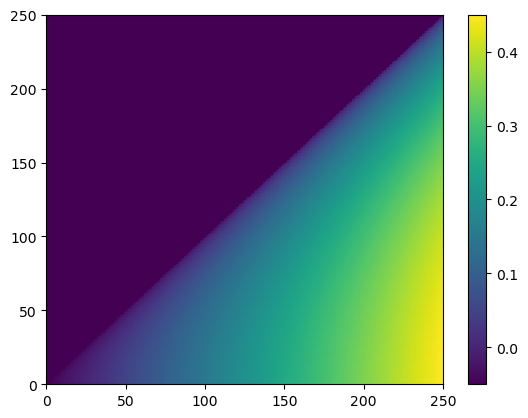

In [15]:
plt.pcolor(re_eig[:, :, 1, 1])
plt.colorbar()

In [ ]:
# Same effect is there, though it is less pronounced

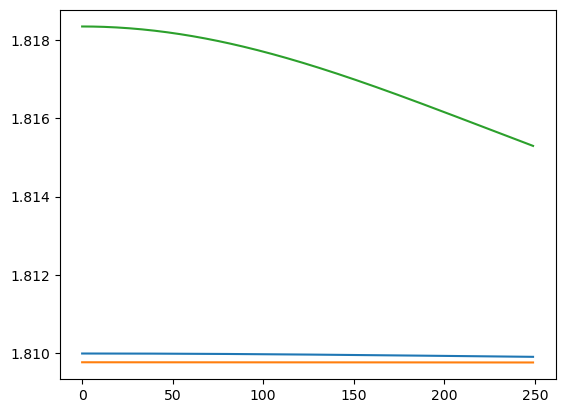

In [73]:
plt.plot(lqgscore[:, 20, 1])
plt.plot(lqgscore[:, 5, 1])
plt.plot(lqgscore[:, 120, 1])

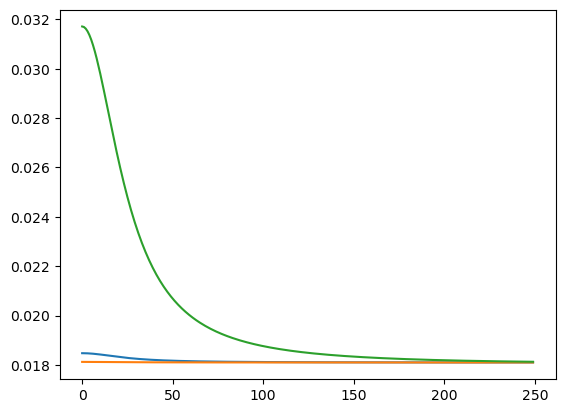

In [72]:
plt.plot(fccascore[:, 20, 1])
plt.plot(fccascore[:, 5, 1])
plt.plot(fccascore[:, 120, 1])

In [ ]:
# Make sure the unstable region is given as nan and not 0. Normalize scores to max and use
# a consistent colormap

In [122]:
fccascore[12, 128, 1]

0.03064716942044237

In [115]:
np.unravel_index(np.nanargmax(fccascore[..., i]), (250, 250))

(6, 128)

In [128]:
np.sort(fccascore[np.invert(np.isnan(fccascore[..., 1])), 1].ravel())[-200:]

array([0.03182128, 0.03182794, 0.03182923, 0.03183407, 0.0318347 ,
       0.03183495, 0.03183701, 0.03183983, 0.03184616, 0.03184692,
       0.03184735, 0.03185249, 0.03185297, 0.03185953, 0.03185962,
       0.0318627 , 0.03186486, 0.03186511, 0.03186563, 0.03186916,
       0.03187203, 0.03188092, 0.03188166, 0.03190359, 0.03190623,
       0.03191499, 0.03191622, 0.03192016, 0.03192719, 0.03192805,
       0.03193731, 0.03193941, 0.03194161, 0.0319427 , 0.03194576,
       0.03194595, 0.03195581, 0.03195668, 0.03195873, 0.03195946,
       0.03196809, 0.03196836, 0.03197019, 0.03197126, 0.03197283,
       0.03197805, 0.03198001, 0.03199036, 0.03200144, 0.03200352,
       0.03200553, 0.03200645, 0.03201604, 0.03202008, 0.03202513,
       0.03203115, 0.03203131, 0.03203179, 0.03203229, 0.03203414,
       0.03203935, 0.03204293, 0.03204606, 0.03205534, 0.03205808,
       0.03205876, 0.03206067, 0.03206236, 0.03206412, 0.03206724,
       0.03207195, 0.03207565, 0.03208004, 0.03208259, 0.03208

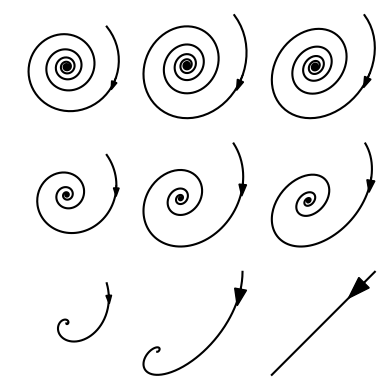

In [54]:
# Trajectories for the continuous time parameterization
# Plot trajectories for fixed theta, varying delta, and then fixed delta, varying theta
fig, ax = plt.subplots(3, 3, figsize=(4, 4))

# th1 = 0.15
# d1 = np.array([0.01, 0.05, 0.1])

# d2 = 0.045
# th2 = np.array([0.15, 0.325, 0.5])
# #th2str = np.array([r'$\theta = \pi/14$, ', r'$\theta = \pi/8, $', r'$\theta = \pi/4, $'])

# Reverse order so smallest is at the bottom visually
d = np.array([0.01, 0.05, 0.1])
th = np.array([0.5, 0.3, 0.1])

x0 = 1/np.sqrt(2) * np.array([1,1])

for i in range(3):
    for j in range(3):
        A = np.array([[-0.05 - d[j], th[i]], [-1*th[i], -0.05 + d[j]]])
        x = np.array([scipy.linalg.expm(A * k) @ x0 for k in np.linspace(0, 100, 500)])
        ax[i, j].plot(x[:, 0], x[:, 1], color='k', alpha=1.0)
        aidx = 10
        ax[i, j].arrow(x[aidx, 0], x[aidx, 1], 
                x[aidx + 1, 0] - x[aidx, 0], x[aidx + 1, 1] - x[aidx, 1], 
                head_width=0.1, color="k")


        #ax[i, j].set_title(r"$\delta =$" + ' %.2f, ' % d[i] +  r'$\theta = %.2f, $' % th[j], fontsize=14)
        ax[i, j].axis('off')


for i in range(3):
        ax[i, 0].set_xlim([-1, 1])
        ax[i, 0].set_ylim([-1, 1])

fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/2Dtraj_examples.pdf', bbox_inches='tight', pad_inches=0)


In [124]:
np.nanmin(pcascore[..., 1])

4.605170185988091

In [137]:
xx = np.log10(pcascore[..., 1].copy())

In [139]:
np.nanmax(xx)

1.2857834612134207

(array([2.3095e+04, 5.5470e+03, 2.3190e+03, 9.2500e+02, 3.3000e+02,
        1.1300e+02, 1.3000e+01, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333, 1.        , 1.16666667, 1.33333333, 1.5       ,
        1.66666667]),
 <BarContainer object of 10 artists>)

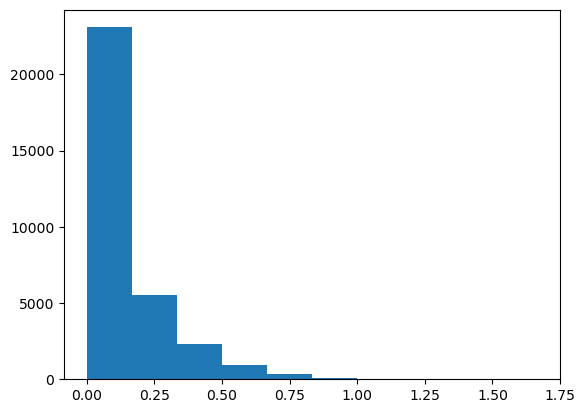

In [144]:
xx = np.log10(pcascore[..., 1].copy())
xx -= np.nanmin(xx)
xx /= np.nanmax(xx) * .6
plt.hist(xx.ravel())

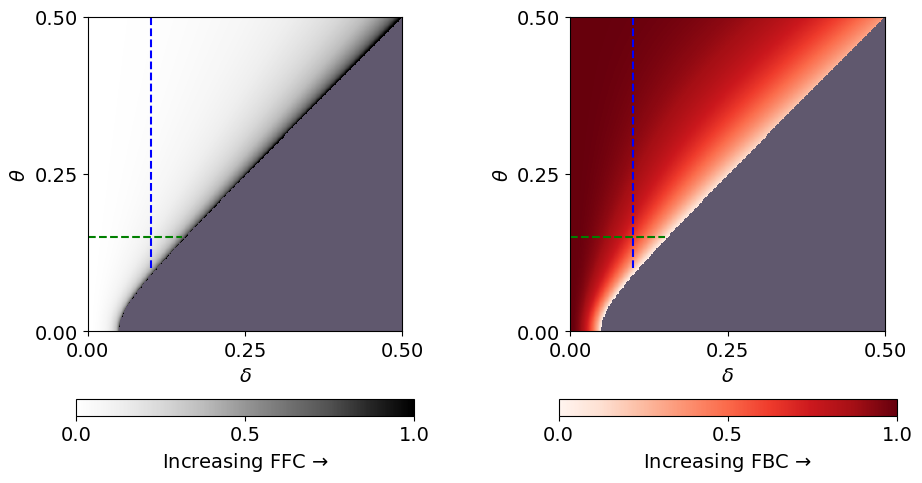

In [179]:
# Plot just the continuous time results. Judiciously scale colormaps to highlight the desired effects
# Use only the LQG score and the FCCA score
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# X, Y = np.meshgrid(theta, delta)
# ax[0].plot_surface(X, Y, fccascore)
# ax[1].plot_surface(X, Y, pcascore)
cmap = copy(matplotlib.cm.get_cmap('Greys'))
cmap.set_bad(color='#60586e')

d = [delta, delta2]
t = [theta, theta2]
xx = pcascore[..., 1].copy()
xx -= np.nanmin(xx)
xx /= np.nanquantile(xx, 0.99)
im0 = ax[0].imshow(xx, vmin=0, vmax=1, cmap=cmap, 
                   extent=[d[i][0], d[i][-1], t[i][-1], t[i][0]])
ax[0].invert_yaxis()
ax[0].set_aspect(1)
ax[0].set_yticks([0, 0.25, 0.5])
ax[0].set_xticks([0., 0.25, 0.5])

# ax[i, 0].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[0].set_ylabel(r'$\theta$', fontsize=14)
ax[0].set_xlabel(r'$\delta$', fontsize=14)
ax[0].tick_params(axis='both', labelsize=14)
cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
cb.ax.set_xlabel('Increasing FFC ' + r'$\to$', fontsize=14)
cb.set_ticks([0, 0.5, 1.0])
cb.ax.tick_params(labelsize=14)





fccascore[np.isclose(fccascore, 0)] = np.nan
cmap = copy(matplotlib.cm.get_cmap('Reds'))
cmap.set_bad(color='#60586e')
xx = fccascore[..., 1].copy()
xx -= np.nanmin(xx)
xx /= np.nanmax(xx)

im1 = ax[1].imshow(1 - xx, vmin=0., 
                    vmax=1.0, cmap=cmap, 
                    extent=[d[i][0], d[i][-1], t[i][-1], t[i][0]])
ax[1].invert_yaxis()
ax[1].set_aspect(aspect[i])
ax[1].set_yticks([0, 0.25, 0.5])
ax[1].set_xticks([0., 0.25, 0.5])
# ax[i, 1].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[1].set_ylabel(r'$\theta$', fontsize=14)
ax[1].set_xlabel(r'$\delta$', fontsize=14)
ax[1].tick_params(axis='both', labelsize=14)
cb = fig.colorbar(im1, ax=ax[1], orientation='horizontal', shrink=0.75)
# cb.ax.invert_xaxis()
cb.ax.set_xlabel('Increasing FBC ' + r'$\to$', fontsize=14)
cb.set_ticks([0, 0.5, 1.0])
cb.ax.tick_params(labelsize=14)
lqgscore[np.isclose(lqgscore, 0)] = np.nan

xx = lqgscore[..., 1]
xx -= np.nanmin(xx)
xx /= np.nanmax(xx)

# im2 = ax[2].imshow(1 - xx, vmin=0, 
#                         vmax=1.0, cmap=cmap, 
#                         extent=[d[i][0], d[i][-1], t[i][-1], t[i][0]])
# ax[2].invert_yaxis()
# ax[2].set_aspect(aspect[i])
# ax[2].set_yticks([0, 0.25, 0.5])
# ax[2].set_xticks([0., 0.05, 0.1])

# # ax[2].set_ylabel(r'$\theta$', fontsize=16)
# # ax[2].set_xlabel(r'$\delta$', fonts)

# cb = fig.colorbar(im2, ax=ax[2], orientation='horizontal')
# # cb.ax.invert_xaxis()
# cb.ax.set_xlabel('Increasing LQG optimality' + r'$\to$')
# cb.set_ticks([0, 0.5, 1.0])

# Add horizontal lines to cutout parts of parameter space
th1 = 0.15
d2 = 0.045
ax[0].vlines(0.1, 0.1, 0.5, 'b', 'dashed')
ax[0].hlines(0.15, 0, 0.15, 'g', 'dashed')

ax[1].vlines(0.1, 0.1, 0.5, 'b', 'dashed')
ax[1].hlines(0.15, 0, 0.15, 'g', 'dashed')
 
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/2D_contr_heatmaps.pdf')

In [ ]:
# Create an inset - zoom into the boundary for FFC


(array([1.2041e+04, 4.3450e+03, 2.9850e+03, 2.2400e+03, 1.7590e+03,
        1.4280e+03, 1.1620e+03, 9.6300e+02, 8.0300e+02, 6.7500e+02,
        5.7800e+02, 4.8100e+02, 4.1000e+02, 3.5400e+02, 2.9500e+02,
        2.5700e+02, 2.1800e+02, 1.9400e+02, 1.5800e+02, 1.3700e+02,
        1.1900e+02, 1.0300e+02, 9.3000e+01, 7.3000e+01, 6.9000e+01,
        4.9000e+01, 5.4000e+01, 3.9000e+01, 3.3000e+01, 3.2000e+01,
        3.5000e+01, 2.4000e+01, 1.4000e+01, 1.4000e+01, 1.4000e+01,
        1.2000e+01, 1.4000e+01, 1.2000e+01, 1.1000e+01, 9.0000e+00,
        1.0000e+01, 9.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

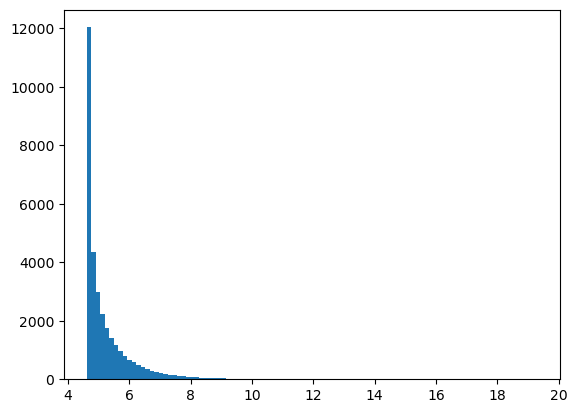

In [123]:
plt.hist(pcascore[..., 1].ravel(), bins=100)

In [ ]:
np.nanmin(yy)

In [81]:
np.min(xx)

0.0

(250, 250, 2)

(array([2.8121e+04, 3.0820e+03, 6.6400e+02, 1.5900e+02, 3.4000e+01,
        4.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

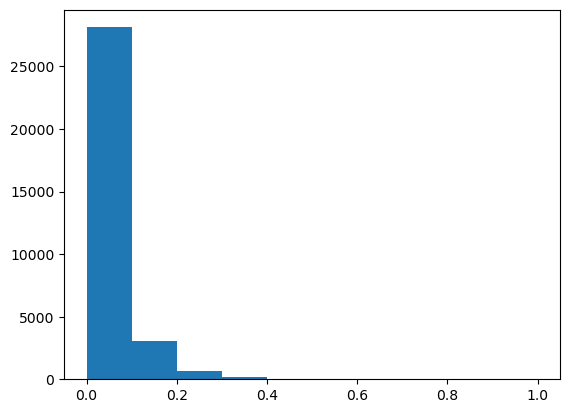

In [110]:
plt.hist(epca.ravel())

In [121]:
np.nanmin(pcascore[..., 1])

4.605170185988091

In [164]:
np.nanquantile(pcascore[..., 1].ravel(), 0.9)

6.261463746209208

In [15]:
# Re-do the calculation in a dense grid near the boundary
# Why does this attempt at a direct parameterization behave so differently? What are the other axes along which these matrices can vary?

delta = np.linspace(0.15, 0.2, 250)
theta = np.linspace(0.15, 0.2, 250)

fccascore_dense = np.zeros((theta.size, len(delta)))
pcascore_dense = np.zeros((theta.size, len(delta)))

for i in range(theta.size):
    for j in range(len(delta)):
        Ac2 = np.array([[-0.05 - delta[j], theta[i]], [-1*theta[i], -0.05 + delta[j]]])
        try:
            assert(np.max(np.real(np.linalg.eigvals(Ac2))) < 0)
        except:
            # print(delta[j])
            fccascore_dense[i, j] = np.nan
            pcascore_dense[i, j] = np.nan
            continue            
        # iml[i, j] = np.imag(np.linalg.eigvals(Ac)[0])
        # ssnorm[i, j] = np.linalg.norm(Ac - 0.5 * (Ac - Ac.T))/np.linalg.norm(Ac)

        fccascore_dense[i, j] = FCCA_score(Ac2)
        pcascore_dense[i, j] = np.linalg.slogdet(scipy.linalg.solve_continuous_lyapunov(Ac2, np.eye(Ac.shape[0])))[1]

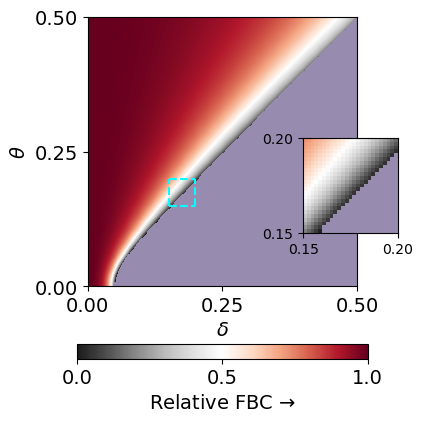

In [28]:
# Plot as as a ratio between normalized scores on an RdGy colormap
# Plot just the continuous time results. Judiciously scale colormaps to highlight the desired effects
# Use only the LQG score and the FCCA score
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# X, Y = np.meshgrid(theta, delta)
# ax[0].plot_surface(X, Y, fccascore)
# ax[1].plot_surface(X, Y, pcascore)
cmap = copy(matplotlib.cm.get_cmap('RdGy_r'))
cmap.set_bad(color='#988bb0')

d = [delta, delta2]
t = [theta, theta2]
th1 = 0.15
d1 = np.array([0.01, 0.05, 0.1])

d2 = 0.045
th2 = np.array([0.15, 0.325, 0.5])
aspect = [0.19, 0.2]
i = 1
xx = pcascore[..., 1].copy()
xx -= np.nanmin(xx)
xx /= np.nanquantile(xx, 0.99)

yy = fccascore[..., 1].copy()
yy -= np.nanmin(yy)
yy /= np.nanmax(yy)
yy = 1 - yy

#zz = np.log10(yy) - np.log10(xx)
zz = np.divide(yy, yy + xx)

im0 = ax.imshow(zz, vmin=0, vmax=1, cmap=cmap, 
                   extent=[d[i][0], d[i][-1], t[i][-1], t[i][0]])
ax.invert_yaxis()
ax.set_aspect(1)
ax.set_yticks([0, 0.25, 0.5])
# ax[i, 0].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax.set_ylabel(r'$\theta$', fontsize=14)
ax.set_xticks([0., 0.25, 0.5])
ax.set_xlabel(r'$\delta$', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
cb = fig.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.75)
cb.ax.set_xlabel('Relative FBC ' + r'$\to$', fontsize=14)
cb.set_ticks([0, 0.5, 1.0])
cb.ax.tick_params(labelsize=14)


axin = ax.inset_axes([0.8, 0.2, 0.35, 0.35])
# xx = pcascore_dense.copy()
# xx -= np.nanmin(pcascore[..., 1])
# xx /= np.nanquantile(pcascore[..., 1], 0.99)

# yy = fccascore_dense.copy()
# yy -= np.nanmin(fccascore[..., 1])
# yy /= np.nanmax(fccascore[..., 1])
# yy = 1 - yy
# zz = np.divide(yy, yy + xx)

im0 = axin.imshow(zz, vmin=0, vmax=1, cmap=cmap, 
                   extent=[d[i][0], d[i][-1], t[i][-1], t[i][0]])
# im0 = axin.imshow(zz, vmin=0, vmax=1, cmap=cmap, 
#                    extent=[0.15, 0.2, 0.2, 0.15])
axin.set_xlim([0.15, 0.2])
axin.set_ylim([0.15, 0.2])
axin.set_yticks([0.15, 0.2])
ax.hlines(0.15, 0.15, 0.2, 'cyan', 'dashed')
ax.hlines(0.2, 0.15, 0.2, 'cyan', 'dashed')
ax.vlines(0.15, 0.15, 0.2, 'cyan', 'dashed')
ax.vlines(0.2, 0.15, 0.2, 'cyan', 'dashed')

#ax.set_xlim([0, 0.1])
#ax.set_ylim([0, 0.1])
fig.savefig('/home/akumar/nse/neural_control/figs/synth/relative_heatmap.pdf', bbox_inches='tight', pad_inches=0.1)

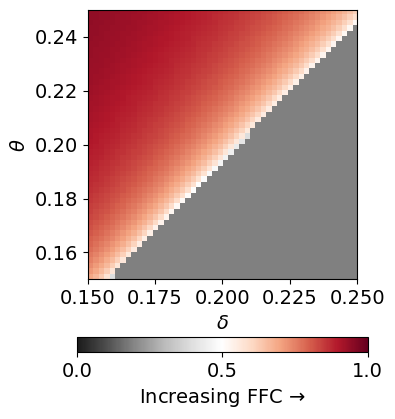

In [190]:
# Plot as as a ratio between normalized scores on an RdGy colormap
# Plot just the continuous time results. Judiciously scale colormaps to highlight the desired effects
# Use only the LQG score and the FCCA score
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# X, Y = np.meshgrid(theta, delta)
# ax[0].plot_surface(X, Y, fccascore)
# ax[1].plot_surface(X, Y, pcascore)
cmap = copy(matplotlib.cm.get_cmap('RdGy_r'))
cmap.set_bad(color='grey')

d = [delta, delta2]
t = [theta, theta2]
th1 = 0.15
d1 = np.array([0.01, 0.05, 0.1])

d2 = 0.045
th2 = np.array([0.15, 0.325, 0.5])
aspect = [0.19, 0.2]
i = 1
xx = pcascore[..., 1].copy()
xx -= np.nanmin(pcascore[..., 1])
xx /= np.nanquantile(pcascore[..., 1], 0.99)

yy = fccascore[..., 1].copy()
yy -= np.nanmin(fccascore[..., 1])
yy /= np.nanmax(fccascore[..., 1])
yy = 1 - yy

#zz = np.log10(yy) - np.log10(xx)
zz = np.divide(yy, yy + xx)

im0 = ax.imshow(zz, vmin=0, vmax=1, cmap=cmap, 
                   extent=[0, 0.5, 0.5, 0.])
ax.set_xlim([0.15, 0.25])
ax.set_ylim([0.15, 0.25])
ax.set_aspect(1)
#ax.set_yticks([0, 0.25, 0.5])
# ax[i, 0].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax.set_ylabel(r'$\theta$', fontsize=14)
#ax.set_xticks([0., 0.25, 0.5])
ax.set_xlabel(r'$\delta$', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
cb = fig.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.75)
cb.ax.set_xlabel('Increasing FFC ' + r'$\to$', fontsize=14)
cb.set_ticks([0, 0.5, 1.0])
cb.ax.tick_params(labelsize=14)

#ax.set_xlim([0, 0.1])
#ax.set_ylim([0, 0.1])

In [67]:
np.nanmax(xx)

1.0

In [69]:
np.nanmax(yy)

0.9819024984394501

In [202]:
import pdb

In [191]:
# Find the straight line from the parameter space to the instability boundary..
# First, need to define the stability boundary...
th_stability = np.zeros(len(delta2))
offset = 10
th_stability[0:offset] = np.nan
pcascore[np.isclose(pcascore, 0)] = np.nan
for j, d in enumerate(delta2[offset:]):
    if not np.any((np.isnan(pcascore[:, j + offset, 1]))):
        th_stability[j + offset] = np.nan
    else:
        # th_stability[j] = theta2[np.argmin[]]
        th_stability[j + offset] = theta2[np.where(np.invert(np.isnan(pcascore[:, j + offset, 1])))[0][0]]

In [192]:
# Interpolate the delta/theta pairs 
d_stability = delta2[np.invert(np.isnan(th_stability))]
th_stability = th_stability[np.invert(np.isnan(th_stability))]

In [193]:
from scipy.interpolate import interp1d

In [194]:
stability_boundary = interp1d(d_stability, th_stability)

In [195]:
# Brute force way to do it: For each point in the parameter space, just find the 
# closest point on the stability boundary. 
dist_to_stable = np.zeros((theta2.size, delta2.size))
re_eig = np.zeros((theta2.size, delta2.size))
for i in range(theta2.size):
    for j in range(delta2.size):
        dist = []
        A_ = np.array([[0.05 - delta2[j], theta2[i]], [-1*theta2[i], 0.05 + delta2[j]]])
        for k in range(len(th_stability)):
            A = np.array([[0.05 - d_stability[k], th_stability[k]], 
                          [-1*th_stability[k], 0.05 + d_stability[k]]])            
            
            # Note that we can actually calculate an L2 norm here
            dist.append(np.linalg.norm(A - A_, ord='fro'))
        dist_to_stable[i, j] = np.min(dist)
        re_eig[i, j] = np.max(np.real(np.linalg.eigvals(A_)))

In [79]:
# 0.9 lol
scipy.stats.spearmanr(zz.ravel(), 1 - xx.ravel())

SpearmanrResult(correlation=0.9082710230214766, pvalue=0.0)

SpearmanrResult(correlation=0.9029460945584332, pvalue=0.0)
SpearmanrResult(correlation=-0.8371740338331899, pvalue=0.0)


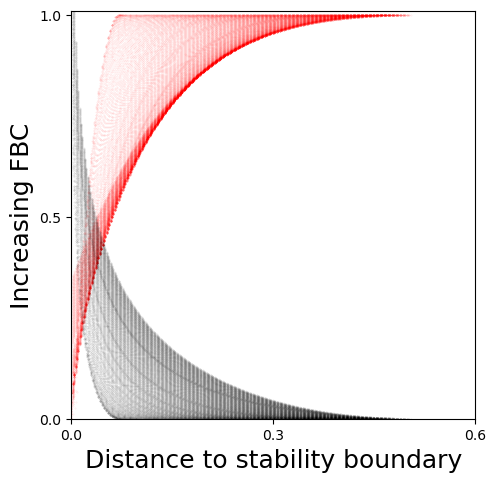

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
xx = fccascore[..., 1]
xx -= np.nanmin(xx)
xx /= np.nanmax(xx)
zz = dist_to_stable[np.invert(np.isnan(xx))]
#zz = re_eig[np.invert(np.isnan(xx))]
xx = xx[np.invert(np.isnan(xx))]


ax.scatter(zz.ravel(), 1 - xx.ravel(), s=0.1, c='red', alpha=0.1)
print(scipy.stats.spearmanr(zz.ravel(), 1 - xx.ravel()))
xx = pcascore[..., 1].copy()
xx -= np.nanmin(xx)
xx /= np.nanquantile(xx, 0.99)

zz = dist_to_stable[np.invert(np.isnan(xx))]
#zz = re_eig[np.invert(np.isnan(xx))]
xx = xx[np.invert(np.isnan(xx))]

ax.scatter(zz.ravel(), xx.ravel(), s=0.1, c='k', alpha=0.1)

print(scipy.stats.spearmanr(zz.ravel(), xx.ravel()))

# ax[1].hexbin(dist_to_stable.ravel(), 1 - xx.ravel(), gridsize=250, cmap='Reds')
ax.set_aspect(0.6)
ax.set_xticks([0, 0.3, 0.6])
ax.set_yticks([0, 0.5, 1])
ax.set_xlim([0, 0.6])
ax.set_ylim([0, 1.01])
ax.set_ylabel('Increasing FBC', fontsize=18)
ax.set_xlabel('Distance to stability boundary', fontsize=18)

# mask the dist_to_stable point where the fcca score is nan
cmap = copy(matplotlib.cm.get_cmap('Reds'))
cmap.set_bad(color='grey')
dist_to_stable[np.isnan(fccascore[..., 1])] = np.nan

# Add a vertical line to 
#cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/2D_stability_subplot.png')

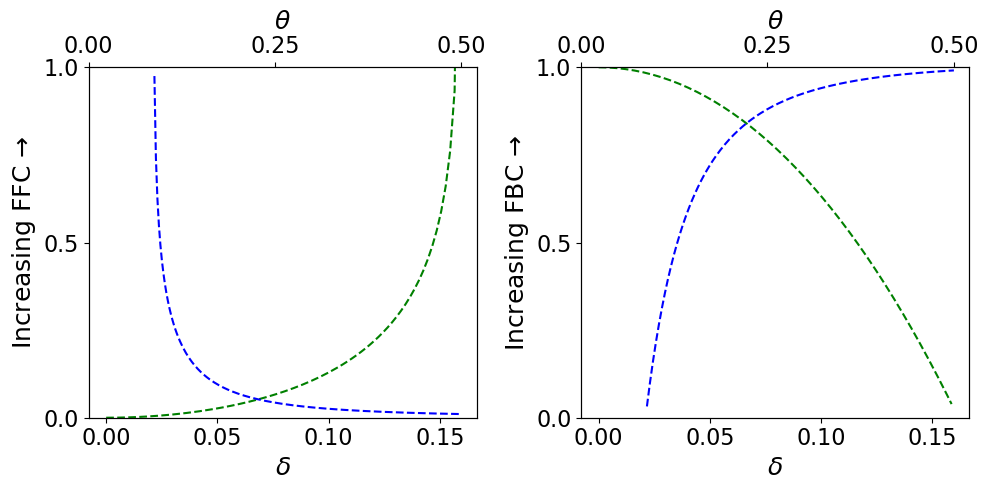

In [210]:
# Plot the behavior of the functions along the cutouts (normalized)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

th1 = 0.15
d2 = 0.1
# Plot data along the green and blue contours
idx1 = np.argmin(np.abs(theta2 - th1))
idx2 = np.argmin(np.abs(delta2 - d2))

a = ax[0].twiny()
xx = pcascore[..., 1].copy()
xx -= np.nanmin(xx)
xx /= np.nanquantile(xx, 0.99)

ax[0].plot(delta2, xx[idx1, :], 'g', linestyle='dashed')
a.plot(theta2, xx[:, idx2], 'b', linestyle='dashed')
ax[0].set_ylabel('Increasing FFC ' + r'$\to$', fontsize=18)
#ax[0].set_yticks([0, 0.125, 0.25])
#ax[0].set_xticks([0, 0.05, 0.1])
a.set_xticks([0, 0.25, 0.5])
a.tick_params(axis='both', labelsize=16)
ax[0].set_xlabel(r'$\delta$', fontsize=18)
a.set_xlabel(r'$\theta$', fontsize=18)

a.set_ylim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.5, 1])



a = ax[1].twiny()
xx = fccascore[..., 1]
xx -= np.nanmin(xx)
xx /= np.nanmax(xx)
ax[1].plot(delta2, 1 - xx[idx1, :], 'g', linestyle='dashed')
a.plot(theta2, 1 - xx[:, idx2], 'b', linestyle='dashed')
ax[1].set_ylabel('Increasing FBC ' + r'$\to$', fontsize=18)
ax[1].set_yticks([0, 0.5, 1.0])
#ax[1].set_xticks([0, 0.05, 0.1])
a.set_xticks([0, 0.25, 0.5])
ax[1].set_xlabel(r'$\delta$', fontsize=18)

#a.set_xticks([0, np.pi/6, np.pi/3])
#a.set_xticklabels([0, r'$\pi/6$', r'$\pi/3$'])
a.set_xlabel(r'$\theta$', fontsize=18)
a.tick_params(axis='both', labelsize=16)
ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_ylim([0, 1])
ax[1].set_yticks([0, 0.5, 1])

# a = ax[2].twiny()
# xx = lqgscore[..., 1]
# xx -= np.nanmin(xx)
# xx /= np.nanmax(xx)
# ax[2].plot(delta2, 1 - xx[idx1, :], 'g', linestyle='dashed')
# a.plot(theta2, 1 - xx[:, idx2], 'b', linestyle='dashed')
# ax[2].set_ylabel('Increasing FFC ' + r'$\to$')
# ax[2].set_yticks([0, 0.5, 1.0])
# ax[2].set_xticks([0, 0.05, 0.1])
# a.set_xticks([0, 0.25, 0.5])
# ax[2].set_xlabel(r'$\delta$')

# #a.set_xticks([0, np.pi/6, np.pi/3])
# #a.set_xticklabels([0, r'$\pi/6$', r'$\pi/3$'])
# a.set_xlabel(r'$\theta$')

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/2D_contr_contours.png', bbox_inches='tight', pad_inches=0)

In [189]:
re_eig.shape

(250, 250, 2, 2)

Text(0.5, 0, 'Real eigenvalues')

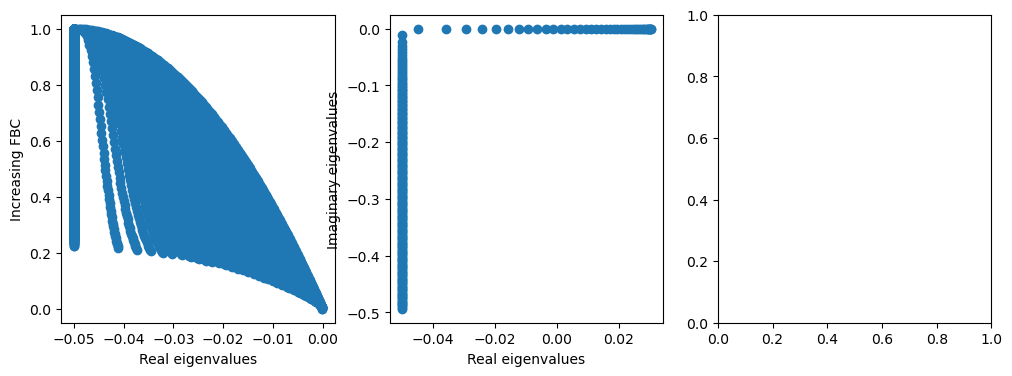

In [198]:
# Plot the sensitivity of the objective functions to the eigenvalues
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

xx = fccascore[..., 1]
xx -= np.nanmin(xx)
xx /= np.nanmax(xx)

# Distance from stability boundary?

ax[0].scatter(np.real(np.max(re_eig[..., 1], axis=-1)).ravel(), 1 - xx.ravel())
ax[0].set_xlabel('Real eigenvalues')
ax[0].set_ylabel('Increasing FBC')

x = np.real(np.max(re_eig[:, 200, 1], axis=-1)).ravel()
y = np.real(np.max(im_eig[:, 200, 1], axis=-1)).ravel()
ax[1].scatter(x, y)
ax[1].set_ylabel('Imaginary eigenvalues')
ax[1].set_xlabel('Real eigenvalues')
#ax[1].set_xlim([-.1, .050])

# ax[1].scatter(im_eig.ravel(), lqgscore.ravel())
# ax[1].set_xlabel('Imaginary eigenvalues')
# ax[1].set_ylabel('LQG score')


# fig.tight_layout()
# fig.savefig('/home/akumar/nse/neural_control/figs/synth/2Drot_debug1.pdf', bbox_inches='tight', pad_inches=0)